# Covid 19 data plotter

With the following cell, the data is updated. Running it the first time downloads ~360 MB of data. 

(File size might be higher, depending on the number of days without lockdown since the creation of this file)

In [1]:
!git submodule update --init
#!git submodule update

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta
import pandas as pd
import os
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
def load_hopkis_data(sdate=date(2020,1,22), edate=date(2050,1,1), nbDaysbtw2dates=1, path="COVID-19"):
    """ Reads and returns the John Hoppkins university COVID 19 dataset
    
    Parameters:
    sdate (datetime.date): Date where to start reading
    edate (datetime.date): Date where to stop reading
    nbDaysbtw2dates (int): only read data for evry nbDaysbtw2dates'th day
    path (string): base folder for data

    Returns:
    pandas.dataframe: Full dataset
    
    """
    
    basepath = "csse_covid_19_data/csse_covid_19_daily_reports"
    mypath = os.path.join(path, basepath)

    date_modified=sdate
    dates=[sdate]

    while date_modified<edate:
        date_modified+=timedelta(days=nbDaysbtw2dates) 
        dates.append(date_modified)


    alldata = None
    for date in dates:
        filename = f"{date.month:02d}-{date.day:02d}-{date.year}.csv"
        fullpath = os.path.join(mypath, filename)

        if os.path.isfile(fullpath):
            with open(fullpath, "r") as file:
                header = file.readline()
        else:
            continue

        headerlist = header.split(",")
        country_index = None
        confirmed_index = None
        deaths_index = None
        recovered_index = None
        for i in range(len(headerlist)):
            if headerlist[i].replace("\n", "") in ["Country_Region", "Country/Region"]:
                country_index = i
            if headerlist[i].replace("\n", "") in ["Confirmed"]:
                confirmed_index = i
            if headerlist[i].replace("\n", "") in ["Deaths"]:
                deaths_index = i
            if headerlist[i].replace("\n", "") in ["Recovered"]:
                recovered_index = i

        df = pd.read_csv(   fullpath, 
                            sep=",", 
                            usecols=(country_index, confirmed_index, deaths_index, recovered_index), 
                            header=0,
                            names=["country", "confirmed", "deaths", "recovered"])

        df = df.fillna(0) # replace NaN with 0

        # Sum up the values for different regions in a country e.g. Bundesländer
        df = df.groupby("country").sum()
        df.index.name = "country"
        df.reset_index(inplace=True)


        df["date"] = date
        if alldata is None:
            alldata = df
        else:
            alldata = pd.concat([alldata, df])

    return alldata

In [4]:
# load data
df = load_hopkis_data(date(2020,1,22))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73179 entries, 0 to 191
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    73179 non-null  object 
 1   confirmed  73179 non-null  float64
 2   deaths     73179 non-null  float64
 3   recovered  73179 non-null  float64
 4   date       73179 non-null  object 
dtypes: float64(3), object(2)
memory usage: 3.3+ MB


In [16]:
# make an interactive plot
def f(country="Germany", data="confirmed", days2average=7, cumulative=False):
    # make an example plot
    selection = df[df["country"] == country]
    try:
        # select data
        x = selection["date"].to_numpy()[1:]
        y = selection[data].to_numpy()[1:]
        if not cumulative:
            y = y - selection[data].to_numpy()[:-1]
        
        # take a rolling average
        x_avg = x[days2average-1:]
        y_avg = np.convolve(y, np.ones(days2average), 'valid')/days2average

        #plot
        plt.plot(x_avg, y_avg)
        plt.xlabel("date")
        plt.ylabel( "cumulative "*cumulative+
                    "daily "*(not cumulative)+
                    f"{data}".replace("confirmed", "cases"))

        # As a little bonus, put a red x where the german leaders introduced their "opening strategy"
        if (country=="Germany"):
            d = date(2021,3,3)
            plt.plot(d,y_avg[x_avg==d], "rx")
    except:
        print(f"Data for {country} cannot be processed!")
    

interact(   f, 
            country=np.sort(df["country"].unique()), 
            data=["confirmed", "deaths", "recovered"], 
            days2average=(1, 35, 1), 
            cumulative=False)

interactive(children=(Dropdown(description='country', index=79, options=(' Azerbaijan', 'Afghanistan', 'Albani…

<function __main__.f(country='Germany', data='confirmed', days2average=7, cumulative=False)>

The next cells are just some examples of what one could do with the data!

In this plot, the deaths are scaled and shifted on the x axis. The increased amount of testing is visible in the second wave.

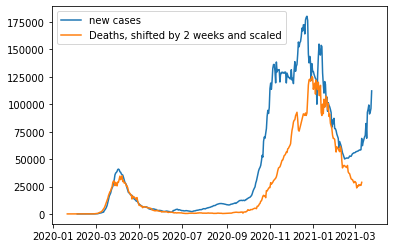

In [13]:
selection = df[df["country"] == "Germany"]
#print(selection["date"].to_numpy())
x = selection["date"].to_numpy()[1:]
y = selection["confirmed"].to_numpy()[1:]-selection["confirmed"].to_numpy()[:-1]
x_avg = x[6:]
y_avg = np.convolve(y, np.ones(7), 'valid')
plt.plot(x_avg, y_avg, label="new cases")

selection = df[df["country"] == "Germany"]
#print(selection["date"].to_numpy())
x = selection["date"].to_numpy()[1:]
y = selection["deaths"].to_numpy()[1:]-selection["deaths"].to_numpy()[:-1]
x_avg = x[6:]
y_avg = np.convolve(y, np.ones(7), 'valid')
def myFunc(x):
    return x - timedelta(days=14)
shiftFunc = np.vectorize(myFunc)
plt.plot(shiftFunc(x_avg), y_avg*20, label="Deaths, shifted by 2 weeks and scaled")
plt.legend()
plt.show()

The next cell produces a kernel that aims to convolve the cases curve into the deaths curve

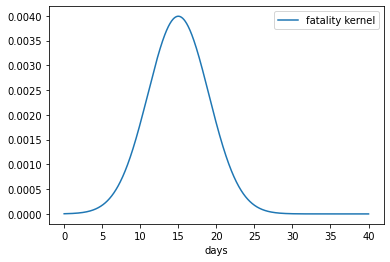

[3.52626861e-06 8.72759863e-06 2.02922748e-05 4.43224030e-05
 9.09436661e-05 1.75298505e-04 3.17424584e-04 5.39957407e-04
 8.62849480e-04 1.29529048e-03 1.82665236e-03 2.41992121e-03
 3.01164061e-03 3.52096459e-03 3.86702308e-03 3.98977557e-03
 3.86702308e-03 3.52096459e-03 3.01164061e-03 2.41992121e-03
 1.82665236e-03 1.29529048e-03 8.62849480e-04 5.39957407e-04
 3.17424584e-04 1.75298505e-04 9.09436661e-05 4.43224030e-05
 2.02922748e-05 8.72759863e-06 3.52626861e-06 1.33842060e-06
 4.77228561e-07 1.59851545e-07 5.02995203e-08 1.48685098e-08
 4.12883605e-09 1.07707124e-09 2.63947658e-10 6.07642012e-11]
(0.039999999999999994, 5.748500427841391e-11)


In [7]:
from scipy.integrate import quad
kernelsize = 40
x = np.linspace(0, kernelsize, 1000)

sigma = 4
my = 15
scale = 0.04 # fatality ratio of covid 19, assumed to be constant
def g(x):
    def nested_g(x):
        return 1/sigma*np.exp(-1/2*(x-my)**2/sigma**2)
    return scale*1/sigma*np.exp(-1/2*(x-my)**2/sigma**2) / quad(nested_g, 0, kernelsize-1)[0]
y = g(x)
plt.plot(x,y, label="fatality kernel")
plt.legend()
plt.xlabel("days")
plt.show()

kernel = g(np.arange(0,kernelsize,1))
print(kernel)
print(quad(g, 0, kernelsize-1))

The kernel is used to recreate the deaths curve

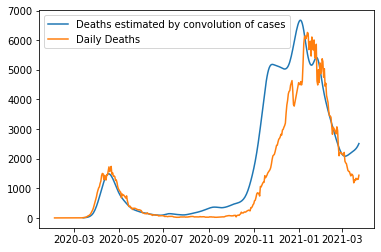

In [8]:
# make an example plot
selection = df[df["country"] == "Germany"]
#print(selection["date"].to_numpy())
x = selection["date"].to_numpy()[1:]
y = selection["confirmed"].to_numpy()[1:]-selection["confirmed"].to_numpy()[:-1]
x_avg = x[6:]
y_avg = np.convolve(y, np.ones(7), 'valid')

convolved_x = x_avg[kernelsize-1:]
convolved_y = np.convolve(y_avg, kernel, 'valid')
plt.plot(convolved_x, convolved_y, label="Deaths estimated by convolution of cases")


selection = df[df["country"] == "Germany"]
x = selection["date"].to_numpy()[1:]
y = selection["deaths"].to_numpy()[1:]-selection["deaths"].to_numpy()[:-1]
x_avg = x[6:]
y_avg = np.convolve(y, np.ones(7), 'valid')

plt.plot(x_avg, y_avg, label="Daily Deaths")
plt.legend()
plt.show()

Bonus cell: Should I stay home?

In [11]:
# Enter information
age = ...
gender = ...
...
...

print("Should I stay home?")
if True:
    print("Yes")

Should I stay home?
Yes
